In [2]:
# Importing Libraries
import ast
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import matplotlib.pyplot as plt  

# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

In [3]:
df_India = df[df['job_country'] == 'India'].copy()

df_skills = df_India.explode('job_skills')

df_skills[['job_title', 'job_skills']]

,job_title,job_skills
16,Big Data Engineer,powershell
16,Big Data Engineer,python
16,Big Data Engineer,sql
16,Big Data Engineer,mysql
16,Big Data Engineer,sql server
...,...,...
785716,Application Support Analyst,c#
785716,Application Support Analyst,sql
785718,Senior Performance QA Analyst,None
785740,AWS System Analyst,aws


Count of skills per job title

In [4]:
# Group by job_skills and job_title_short and count the number of occurrences
df_skills_count = df_skills.groupby(['job_skills', 'job_title_short']).size()

# Name the count column as count
df_skills_count = df_skills_count.reset_index(name='skill_count')

# Sort the values by skill_count in descending order
df_skills_count.sort_values(by='skill_count', ascending=False, inplace=True)

df_skills_count

,job_skills,job_title_short,skill_count
1374,sql,Data Engineer,12993
1088,python,Data Engineer,11568
1089,python,Data Scientist,9248
1327,spark,Data Engineer,7157
103,aws,Data Engineer,6993
...,...,...,...
389,esquisse,Data Scientist,1
887,node.js,Senior Data Analyst,1
753,matlab,Cloud Engineer,1
411,fastapi,Cloud Engineer,1


In [5]:
job_titles = df_skills_count['job_title_short'].unique().tolist()

job_titles = sorted(job_titles[:3])

job_titles

['Data Analyst', 'Data Engineer', 'Data Scientist']

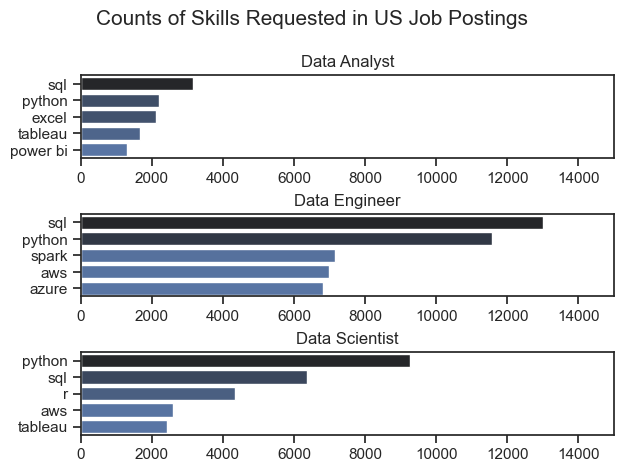

In [7]:
fig, ax = plt.subplots(len(job_titles), 1)

sns.set_theme(style='ticks')

for i, job_title in enumerate(job_titles):
    df_plot = df_skills_count[df_skills_count['job_title_short'] == job_title].head(5)[::-1]
    sns.barplot(data=df_plot, x='skill_count', y='job_skills', ax=ax[i], hue='skill_count', palette='dark:b_r')
    ax[i].set_title(job_title)
    ax[i].invert_yaxis()
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].get_legend().remove()
    ax[i].set_xlim(0, 15000) # make the scales the same

fig.suptitle('Counts of Skills Requested in US Job Postings', fontsize=15)
fig.tight_layout(h_pad=0.5) # fix the overlap
plt.show()

Converting counts to percentage

In [10]:
# Use original df to get the count of job titles
df_job_title_count = df_India['job_title_short'].value_counts().reset_index(name='jobs_total')

#Now we calculate the percentage
df_skills_perc = pd.merge(df_skills_count, df_job_title_count, on='job_title_short', how='left')

df_skills_perc['skill_percent'] = round((df_skills_perc['skill_count'] / df_skills_perc['jobs_total']) * 100)


df_skills_perc

,job_skills,job_title_short,skill_count,jobs_total,skill_percent
0,sql,Data Engineer,12993,19062,68.0
1,python,Data Engineer,11568,19062,61.0
2,python,Data Scientist,9248,13279,70.0
3,spark,Data Engineer,7157,19062,38.0
4,aws,Data Engineer,6993,19062,37.0
...,...,...,...,...,...
1684,esquisse,Data Scientist,1,13279,0.0
1685,node.js,Senior Data Analyst,1,1083,0.0
1686,matlab,Cloud Engineer,1,351,0.0
1687,fastapi,Cloud Engineer,1,351,0.0


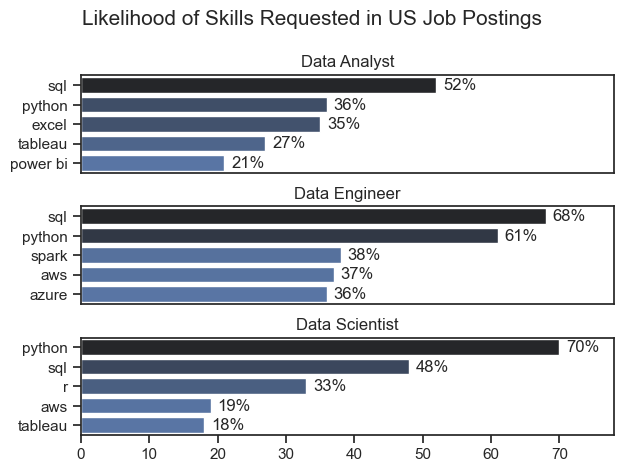

In [ ]:
fig, ax = plt.subplots(len(job_titles), 1)


for i, job_title in enumerate(job_titles):
    df_plot = df_skills_perc[df_skills_perc['job_title_short'] == job_title].head(5)
    sns.barplot(data=df_plot, x='skill_percent', y='job_skills', ax=ax[i], hue='skill_count', palette='dark:b_r')
    ax[i].set_title(job_title)
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].get_legend().remove()
    ax[i].set_xlim(0, 78)
    # remove the x-axis tick labels for better readability
    if i != len(job_titles) - 1:
        ax[i].set_xticks([])

    # label the percentage on the bars
    for n, v in enumerate(df_plot['skill_percent']):
        ax[i].text(v + 1, n, f'{v:.0f}%', va='center')

fig.suptitle('Likelihood of Skills Requested in India Job Postings', fontsize=15)
fig.tight_layout(h_pad=.8)
plt.show()

Highest paying jobs

In [4]:
# filter for the job titles and country
df_India = df[(df['job_country'] == 'India')].dropna(subset=['salary_year_avg'])


job_titles = df_India['job_title_short'].value_counts().index[:6].tolist()

# filter the df for the top 6 job titles
df_India_top6 = df_India[df_India['job_title_short'].isin(job_titles)]

# order the job titles by median salary
job_order = df_India_top6.groupby('job_title_short')['salary_year_avg'].median().sort_values(ascending=False).index

job_titles

['Data Engineer',
 'Data Analyst',
 'Data Scientist',
 'Machine Learning Engineer',
 'Senior Data Engineer',
 'Software Engineer']

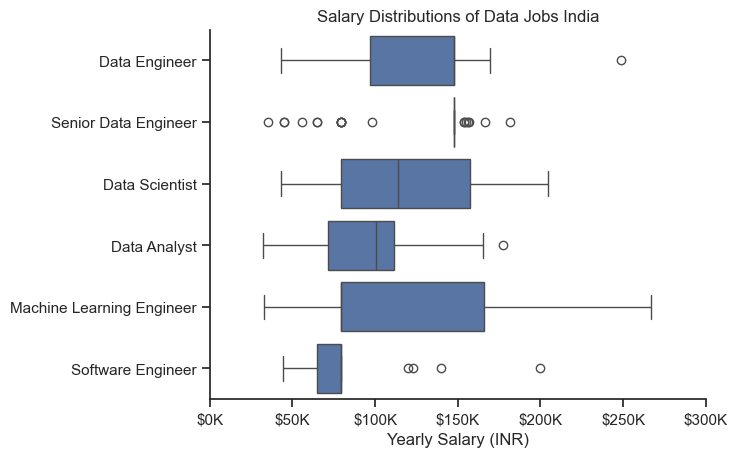

In [7]:
sns.boxplot(data=df_India_top6, x='salary_year_avg', y='job_title_short', order=job_order)
sns.set_theme(style='ticks')
sns.despine()

# this is all the same
plt.title('Salary Distributions of Data Jobs India')
plt.xlabel('Yearly Salary (INR)')
plt.ylabel('')
plt.xlim(0, 300000) 
ticks_x = plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K')
plt.gca().xaxis.set_major_formatter(ticks_x)
plt.show()

Analysing deeper for Data analysts only

In [10]:
df.columns

Index(['job_title_short', 'job_title', 'job_location', 'job_via',
       'job_schedule_type', 'job_work_from_home', 'search_location',
       'job_posted_date', 'job_no_degree_mention', 'job_health_insurance',
       'job_country', 'salary_rate', 'salary_year_avg', 'salary_hour_avg',
       'company_name', 'job_skills', 'job_type_skills'],
      dtype='object')

In [31]:
df_DA_India = df[df['job_title_short'] == 'Data Analyst']
df_DA_India = df_DA_India[df_DA_India['job_country'] == 'India'].copy()

# ✅ Step 2: Extract month from job_posted_date
df_DA_India['job_posted_date'] = pd.to_datetime(df_DA_India['job_posted_date'])
df_DA_India['job_month'] = df_DA_India['job_posted_date'].dt.month



# ✅ Step 3: Group and calculate salary stats
df_DA_India_trend = df_DA_India.groupby('job_month')['salary_year_avg'].agg(
    count='count',
    mean='mean',
    median='median',
    min='min',
    max='max'
).reset_index()

# ✅ Drop rows with NaN values in salary columns (like October)
df_DA_India_trend = df_DA_India_trend.dropna(subset=['mean', 'median'])


# ✅ Step 4: Convert to k and add month names
df_DA_India_trend['mean_k'] = df_DA_India_trend['mean'] / 1000
df_DA_India_trend['median_k'] = df_DA_India_trend['median'] / 1000
df_DA_India_trend['min_k'] = df_DA_India_trend['min'] / 1000
df_DA_India_trend['max_k'] = df_DA_India_trend['max'] / 1000
df_DA_India_trend['Month'] = df_DA_India_trend['job_month'].apply(lambda x: calendar.month_abbr[int(x)])



Summary Salary Table

In [32]:
import calendar

df_summary = df_DA_India_trend.copy()
df_summary['Month'] = df_summary['job_month'].apply(lambda x: calendar.month_abbr[int(x)])

# Convert min and max salary to 'k'
df_summary['min_k'] = df_summary['min'] / 1000
df_summary['max_k'] = df_summary['max'] / 1000

df_summary = df_summary[[
    'Month', 'count', 'mean_k', 'median_k', 'min_k', 'max_k'
]].rename(columns={
    'count': 'No. of Postings',
    'mean_k': 'Avg Salary (k)',
    'median_k': 'Median Salary (k)',
    'min_k': 'Min Salary (k)',
    'max_k': 'Max Salary (k)'
})

# ✅ Round all salary columns to 1 decimal place
df_summary[['Avg Salary (k)', 'Median Salary (k)', 'Min Salary (k)', 'Max Salary (k)']] = \
df_summary[['Avg Salary (k)', 'Median Salary (k)', 'Min Salary (k)', 'Max Salary (k)']].round(1)

print(df_summary)


   Month  No. of Postings  Avg Salary (k)  Median Salary (k)  Min Salary (k)  \
0    Jan               11            98.9              104.5            64.8   
1    Feb                4           259.0              137.5           111.2   
2    Mar               11            87.2               93.6            50.4   
3    Apr                7            83.9               79.2            50.4   
4    May               11           100.1               98.5            49.6   
5    Jun               15            95.9              100.5            57.5   
6    Jul               17            94.3              105.0            50.4   
7    Aug                5            86.2               79.2            57.5   
8    Sep                3            93.7              105.0            64.8   
10   Nov                5            83.4               89.1            32.4   
11   Dec                5            75.6               64.8            55.0   

    Max Salary (k)  
0            165.0

Visualization


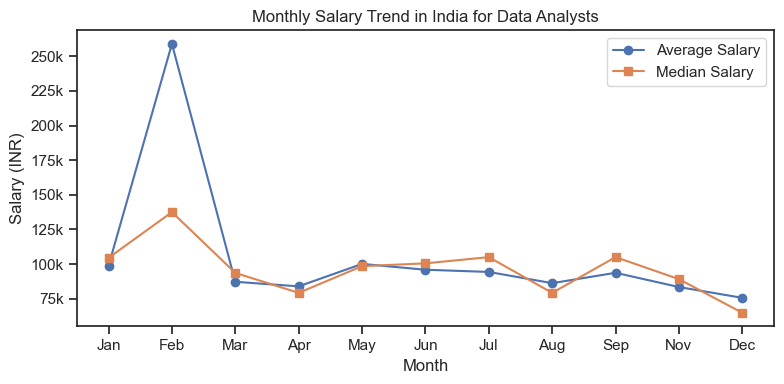

In [38]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter  # 👈 Add this line

def add_k(value, _):
    return f'{int(value)}k'

plt.figure(figsize=(8, 4))
plt.plot(df_summary['Month'], df_summary['Avg Salary (k)'], marker='o', label='Average Salary')
plt.plot(df_summary['Month'], df_summary['Median Salary (k)'], marker='s', label='Median Salary')
plt.title('Monthly Salary Trend in India for Data Analysts')
plt.ylabel('Salary (INR)')
plt.xlabel('Month')

plt.gca().yaxis.set_major_formatter(FuncFormatter(add_k))
plt.legend()
plt.tight_layout()
plt.show()


Most optimal skills to learn for Data analysts in India

In [39]:
df_DA_India = df[(df['job_title_short'] == 'Data Analyst') & (df['job_country'] == 'India')].copy()

# Drop NaN values from the 'salary_year_avg' column for accurate visualization
df_DA_India = df_DA_India.dropna(subset=['salary_year_avg'])

df_DA_India_exploded = df_DA_India.explode('job_skills')

df_DA_India_exploded[['salary_year_avg', 'job_skills']].head(5)

,salary_year_avg,job_skills
11412,50400.0,python
11412,50400.0,sql
11412,50400.0,aws
11412,50400.0,azure
11412,50400.0,excel


In [40]:
# using df_DA find the count of skills and also the median salary for each skill
df_DA_skills = df_DA_India_exploded.groupby('job_skills')['salary_year_avg'].agg(['count', 'median']).sort_values(by='count', ascending=False)

df_DA_skills = df_DA_skills.rename(columns={'count': 'skill_count', 'median': 'median_salary'})

DA_job_count = len(df_DA_India)  # Find count of Data Analyst jobs in US with salary info

df_DA_skills['skill_percent'] = df_DA_skills['skill_count'] / DA_job_count * 100

df_DA_skills = df_DA_skills[df_DA_skills['skill_count'] > 0]

df_DA_skills

,skill_count,median_salary,skill_percent
job_skills,,,
sql,46,96050.0,48.936170
excel,39,98500.0,41.489362
python,36,96050.0,38.297872
tableau,20,108087.5,21.276596
r,18,79200.0,19.148936
...,...,...,...
postgresql,1,165000.0,1.063830
ms access,1,64600.0,1.063830
mysql,1,165000.0,1.063830


In [41]:
skill_limit = 5

df_DA_skills_high_demand = df_DA_skills[df_DA_skills['skill_percent'] > skill_limit]

Scatter plot

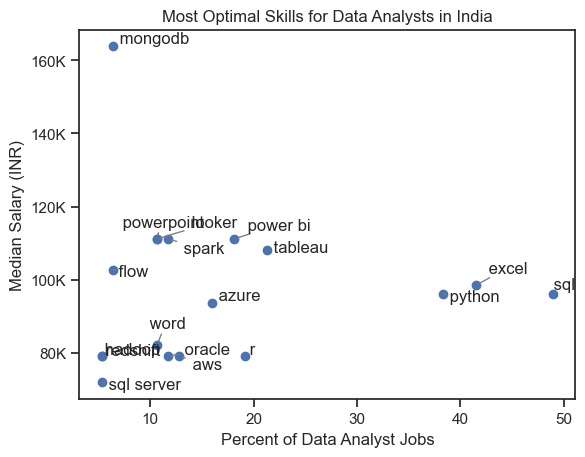

In [43]:
from adjustText import adjust_text

plt.scatter(df_DA_skills_high_demand['skill_percent'], df_DA_skills_high_demand['median_salary'])
plt.xlabel('Percent of Data Analyst Jobs')
plt.ylabel('Median Salary (INR)')  # Assuming this is the label you want for y-axis
plt.title('Most Optimal Skills for Data Analysts in India')

# Get current axes, set limits, and format axes
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'{int(y/1000)}K'))  # Example formatting y-axis

# Add labels to points and collect them in a list
texts = []
for i, txt in enumerate(df_DA_skills_high_demand.index):
    texts.append(plt.text(df_DA_skills_high_demand['skill_percent'].iloc[i], df_DA_skills_high_demand['median_salary'].iloc[i], " " + txt))

# Adjust text to avoid overlap and add arrows
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

plt.show()

Formatting of the chart

In [44]:
df_technology = df['job_type_skills'].copy()

# remove duplicates
df_technology = df_technology.drop_duplicates()

# remove NaN values
df_technology = df_technology.dropna()

# combine all dictionaries into one
technology_dict = {}
for row in df_technology:
    row_dict = ast.literal_eval(row)  # convert string to dictionary
    for key, value in row_dict.items():
        if key in technology_dict:  # if key already exists in technology_dict, add value to existing value
            technology_dict[key] += value
        else:                       # if key does not exist in technology_dict, add key and value
            technology_dict[key] = value

# remove duplicates by converting values to set then back to list
for key, value in technology_dict.items():
    technology_dict[key] = list(set(value))

technology_dict

{'analyst_tools': ['qlik',
  'esquisse',
  'powerbi',
  'sharepoint',
  'outlook',
  'excel',
  'splunk',
  'ssrs',
  'spreadsheet',
  'visio',
  'msaccess',
  'sheets',
  'datarobot',
  'word',
  'tableau',
  'ms access',
  'nuix',
  'looker',
  'sap',
  'dax',
  'cognos',
  'microstrategy',
  'spss',
  'sas',
  'ssis',
  'powerpoint',
  'power bi',
  'alteryx'],
 'programming': ['c#',
  'ruby',
  'bash',
  'powershell',
  'scala',
  'php',
  'javascript',
  'rust',
  'objective-c',
  'lisp',
  'visualbasic',
  'swift',
  'golang',
  'matlab',
  'sass',
  'groovy',
  'erlang',
  'r',
  'solidity',
  'dart',
  'assembly',
  'elixir',
  'nosql',
  'python',
  'css',
  'java',
  'apl',
  'go',
  'vba',
  'kotlin',
  'vb.net',
  'haskell',
  'ocaml',
  'crystal',
  'perl',
  'sql',
  'shell',
  'visual basic',
  'c',
  'no-sql',
  't-sql',
  'typescript',
  'clojure',
  'fortran',
  'f#',
  'pascal',
  'lua',
  'mongodb',
  'html',
  'sas',
  'cobol',
  'delphi',
  'julia',
  'mongo',
  '

In [45]:
# turn dictionary into dataframe
df_technology = pd.DataFrame(list(technology_dict.items()), columns=['technology', 'skills'])

df_technology = df_technology.explode('skills')

df_technology

,technology,skills
0,analyst_tools,qlik
0,analyst_tools,esquisse
0,analyst_tools,powerbi
0,analyst_tools,sharepoint
0,analyst_tools,outlook
...,...,...
9,sync,zoom
9,sync,unify
9,sync,twilio
9,sync,webex


In [46]:
# merge df_DA_skills and df_technology
df_DA_skills_tech = df_DA_skills.merge(df_technology, left_on='job_skills', right_on='skills')

df_DA_skills_tech

,skill_count,median_salary,skill_percent,technology,skills
0,46,96050.0,48.936170,programming,sql
1,39,98500.0,41.489362,analyst_tools,excel
2,36,96050.0,38.297872,programming,python
3,20,108087.5,21.276596,analyst_tools,tableau
4,18,79200.0,19.148936,programming,r
...,...,...,...,...,...
80,1,165000.0,1.063830,databases,postgresql
81,1,64600.0,1.063830,analyst_tools,ms access
82,1,165000.0,1.063830,databases,mysql
83,1,163782.0,1.063830,databases,neo4j


In [47]:
df_DA_skills_tech_high_demand = df_DA_skills_tech[df_DA_skills_tech['skill_percent'] > skill_limit]

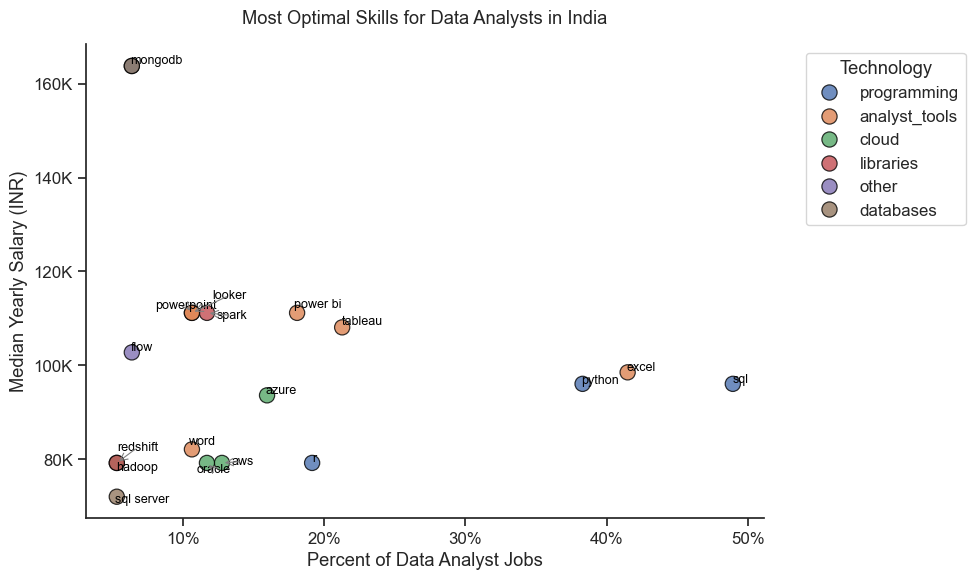

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
from matplotlib.ticker import PercentFormatter, FuncFormatter

# Set style before plotting
sns.set_theme(style='ticks', font_scale=1.1)
plt.figure(figsize=(10, 6))

# Scatter plot with styling
ax = sns.scatterplot(
    data=df_DA_skills_tech_high_demand,
    x='skill_percent',
    y='median_salary',
    hue='technology',
    s=120,              # larger markers for clarity
    alpha=0.8,          # slightly transparent
    edgecolor='black'   # black edges for contrast
)

sns.despine()

# Prepare text labels
texts = []
for i, txt in enumerate(df_DA_skills_high_demand.index):
    texts.append(plt.text(
        df_DA_skills_high_demand['skill_percent'].iloc[i],
        df_DA_skills_high_demand['median_salary'].iloc[i],
        txt,
        fontsize=9,
        fontweight='medium',
        color='black'
    ))

# Adjust text to prevent overlapping
adjust_text(
    texts,
    arrowprops=dict(arrowstyle='->', color='gray', lw=0.8),
    expand_points=(2.5, 2.5),   # adds space around points
    expand_text=(1.2, 1.2),     # space between labels
    force_text=0.8,             # pushes text apart
    force_points=0.5             # prevents overlap with dots
)

# Format axes
ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{int(y/1000)}K'))

# Labels and title
plt.xlabel('Percent of Data Analyst Jobs')
plt.ylabel('Median Yearly Salary (INR)')
plt.title('Most Optimal Skills for Data Analysts in India', pad=15)

# Move legend outside chart for clarity
plt.legend(title='Technology', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()
